## Reference

In the following notebook, the reference datasets will be explored, in order to extract valuable information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.linear_model import LinearRegression


### 1. Crop parameters

In [2]:
crop_param = pd.read_csv("CropParameters.csv")
crop_param.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   %Time        23 non-null     int64  
 1   Stem_elong   23 non-null     object 
 2   Stem_thick   18 non-null     float64
 3   Cum_trusses  18 non-null     float64
 4   stem_dens    22 non-null     float64
 5   plant_dens   23 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.2+ KB


In [3]:
crop_param.rename(columns={"stem_dens ": "stem_dens", "%Time": "Time"}, inplace=True)
crop_param['Time'] = pd.to_datetime(crop_param['Time'], unit='D', origin='1899-12-30')
crop_param.set_index("Time", inplace=True)
crop_param["Stem_elong"] = crop_param["Stem_elong"].astype(float)

In [4]:
crop_param = crop_param.truncate(after="2020-04-22") 
# In this case, the dataset is truncated, due to what is said in the PDF, no more data was collected

# NaN values are subsituted with according and reasonable values
crop_param.iloc[0, 2] = 0
crop_param.iloc[0, 3] = 4

<AxesSubplot:>

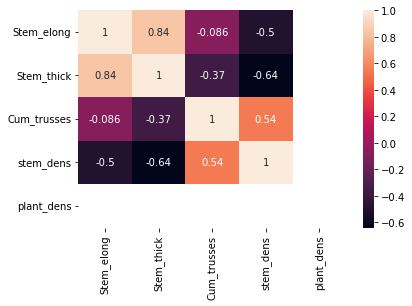

In [5]:
# Correlations
sns.heatmap(crop_param.corr(), annot=True)

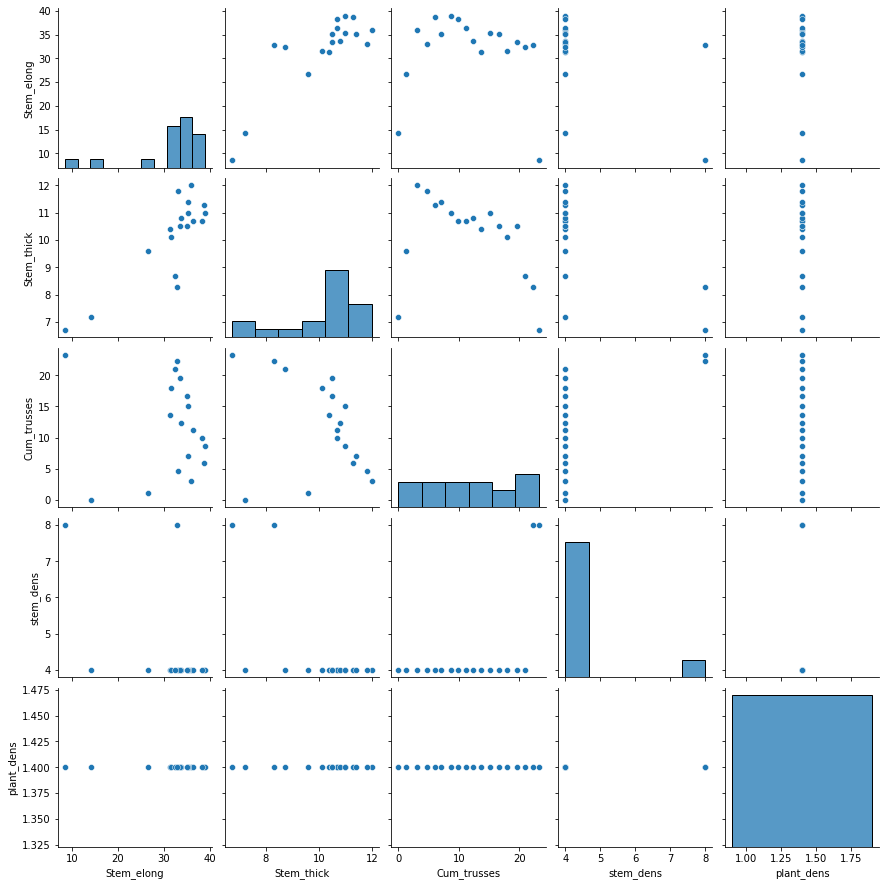

In [6]:
sns.pairplot(crop_param)

Important observations:

- Stem_thick and Stem_elong are positive correlated --> quasi-linear
- Stem_thick and Cum_trusses are negative correlated --> quasi-linear
- Other not much to say about correlations

### 2. Greenhouse Climate

In [7]:
green = pd.read_csv("GreenhouseClimate.csv")
green.info()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18812\3317408743.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  green = pd.read_csv("GreenhouseClimate.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47809 entries, 0 to 47808
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   %time                        47809 non-null  float64
 1   AssimLight                   47809 non-null  object 
 2   BlackScr                     47809 non-null  object 
 3   CO2air                       47809 non-null  object 
 4   Cum_irr                      47809 non-null  object 
 5   EC_drain_PC                  47809 non-null  object 
 6   EnScr                        47809 non-null  object 
 7   HumDef                       47809 non-null  object 
 8   PipeGrow                     47809 non-null  object 
 9   PipeLow                      47809 non-null  object 
 10  Rhair                        47809 non-null  object 
 11  Tair                         47809 non-null  object 
 12  Tot_PAR                      47809 non-null  object 
 13  Tot_PAR_Lamps   

In [8]:
green.rename(columns={"%time": "Time"}, inplace=True)
green['Time'] = pd.to_datetime(green['Time'], unit='D', origin='1899-12-30')

green.set_index("Time", inplace=True)

The dataset will be divided in 3 other datasets, one that contains all the indoor parameters, another that has all the set-point parameters and a final one with the VIP parameters.

In [9]:
sp_cols = []
vip_cols = []
indoor_cols = []

for col in green.columns:
    green[col] = green[col].astype(float)

    if "_sp" in col:
        sp_cols.append(col)
    elif "_vip" in col:
        vip_cols.append(col)
    else:
        indoor_cols.append(col)

indoor_df = green.loc[:, indoor_cols]
sp_df = green.loc[:, sp_cols]
vip_df = green.loc[:, vip_cols]

#### Indoor dataset

In [10]:
indoor_df.isnull().sum() # In this case, most of the columns have 71 missing values, compared to the 47809 entrances, 
# the value is pretty small and those missing values can be dropped.
indoor_df.dropna(inplace=True)

In [11]:
corr_table = indoor_df.corr()
for i in corr_table.index:
    for j in corr_table.columns:
        if i == j:
            continue

        else:
            if np.abs(corr_table.loc[i,j]) >= 0.6:
                print(f"{i} and {j} are correlated, {corr_table.loc[i,j]}")

AssimLight and Tot_PAR_Lamps are correlated, 0.9568654295816702
Cum_irr and water_sup are correlated, 0.9999388896725872
HumDef and Rhair are correlated, -0.938013018823097
HumDef and Tot_PAR are correlated, 0.6443651046801245
HumDef and VentLee are correlated, 0.7099885786965306
Rhair and HumDef are correlated, -0.938013018823097
Rhair and VentLee are correlated, -0.7017905027498985
Tair and Tot_PAR are correlated, 0.7881971574228595
Tot_PAR and HumDef are correlated, 0.6443651046801245
Tot_PAR and Tair are correlated, 0.7881971574228595
Tot_PAR and co2_dos are correlated, 0.7004535526725966
Tot_PAR_Lamps and AssimLight are correlated, 0.9568654295816702
VentLee and HumDef are correlated, 0.7099885786965306
VentLee and Rhair are correlated, -0.7017905027498985
VentLee and Ventwind are correlated, 0.6922023352422673
Ventwind and VentLee are correlated, 0.6922023352422673
co2_dos and Tot_PAR are correlated, 0.7004535526725966
water_sup and Cum_irr are correlated, 0.9999388896725872


#### SetPoint dataset

In [12]:
sp_df.isnull().sum()

assim_sp                       1944
co2_sp                         1522
dx_sp                          1585
int_blue_sp                     198
int_farred_sp                    14
int_red_sp                      198
int_white_sp                     14
scr_blck_sp                    1940
scr_enrg_sp                    1939
t_grow_min_sp                 47809
t_heat_sp                      1946
t_rail_min_sp                  1617
t_vent_sp                      1960
water_sup_intervals_sp_min    41308
window_pos_lee_sp              1960
dtype: int64

In this dataset we have a very heterogenous number of missing values, in this case, different approaches will be taken

In [13]:
# Water sup intervals and t_grow_min have too many missing values, due to that the whole columns have to be dropped
sp_df.drop(columns=["water_sup_intervals_sp_min", "t_grow_min_sp"], inplace=True)
# For the categories with a small number of missing values, the whole entrance will be dropped.
sp_df.drop(sp_df[sp_df["int_blue_sp"].isnull()].index, axis=0, inplace=True)

In [14]:
sp_df.isnull().sum()

assim_sp             1943
co2_sp               1521
dx_sp                1584
int_blue_sp             0
int_farred_sp           0
int_red_sp              0
int_white_sp            0
scr_blck_sp          1939
scr_enrg_sp          1938
t_heat_sp            1945
t_rail_min_sp        1616
t_vent_sp            1959
window_pos_lee_sp    1959
dtype: int64

In [15]:
# The rest of the missing values will be imputed using a KNNImputer, using 3 neighbors to avoid overfitting

imputer = KNNImputer(n_neighbors=3)
cols = sp_df.columns
inds = sp_df.index
data = imputer.fit_transform(sp_df)
sp_df = pd.DataFrame(data=data, columns=cols, index=inds)


In [16]:
corr_table = sp_df.corr()
for i in corr_table.index:
    for j in corr_table.columns:
        if i == j:
            continue

        else:
            if np.abs(corr_table.loc[i,j]) >= 0.6:
                print(f"{i} and {j} are correlated, {corr_table.loc[i,j]}")

int_blue_sp and int_red_sp are correlated, 0.999813681767809
int_blue_sp and int_white_sp are correlated, 0.9994409604783976
int_red_sp and int_blue_sp are correlated, 0.999813681767809
int_red_sp and int_white_sp are correlated, 0.9994409604783976
int_white_sp and int_blue_sp are correlated, 0.9994409604783976
int_white_sp and int_red_sp are correlated, 0.9994409604783976
t_heat_sp and t_vent_sp are correlated, 0.9534226717754951
t_vent_sp and t_heat_sp are correlated, 0.9534226717754951


#### VIP dataset

In this dataset a similar methodology will be followed

In [17]:
vip_df.isnull().sum()

assim_vip                         71
co2_vip                           71
dx_vip                            71
int_blue_vip                   22397
int_farred_vip                 22397
int_red_vip                    22397
int_white_vip                  22397
scr_blck_vip                      71
scr_enrg_vip                      71
t_grow_min_vip                    71
t_heat_vip                        71
t_rail_min_vip                    71
t_ventlee_vip                     71
t_ventwind_vip                    71
water_sup_intervals_vip_min       71
window_pos_lee_vip                71
dtype: int64

In [18]:
vip_df.drop(vip_df[vip_df["scr_blck_vip"].isnull()].index, axis=0, inplace=True)
vip_df.isnull().sum()

assim_vip                          0
co2_vip                            0
dx_vip                             0
int_blue_vip                   22382
int_farred_vip                 22382
int_red_vip                    22382
int_white_vip                  22382
scr_blck_vip                       0
scr_enrg_vip                       0
t_grow_min_vip                     0
t_heat_vip                         0
t_rail_min_vip                     0
t_ventlee_vip                      0
t_ventwind_vip                     0
water_sup_intervals_vip_min        0
window_pos_lee_vip                 0
dtype: int64

In [19]:
imputer = KNNImputer(n_neighbors=3)
cols = vip_df.columns
inds = vip_df.index
data = imputer.fit_transform(vip_df)
vip_df = pd.DataFrame(data=data, columns=cols, index=inds)

In [20]:
corr_table = vip_df.corr()
for i in corr_table.index:
    for j in corr_table.columns:
        if i == j:
            continue

        else:
            if np.abs(corr_table.loc[i,j]) >= 0.6:
                print(f"{i} and {j} are correlated, {corr_table.loc[i,j]}")

int_blue_vip and int_red_vip are correlated, 0.9995917581621522
int_blue_vip and int_white_vip are correlated, 0.9987646142684229
int_red_vip and int_blue_vip are correlated, 0.9995917581621522
int_red_vip and int_white_vip are correlated, 0.9990014521805741
int_white_vip and int_blue_vip are correlated, 0.9987646142684229
int_white_vip and int_red_vip are correlated, 0.9990014521805741
t_grow_min_vip and t_rail_min_vip are correlated, 0.634482122361513
t_heat_vip and t_ventlee_vip are correlated, 0.954893321011079
t_heat_vip and t_ventwind_vip are correlated, 0.8764785068599101
t_rail_min_vip and t_grow_min_vip are correlated, 0.634482122361513
t_ventlee_vip and t_heat_vip are correlated, 0.954893321011079
t_ventlee_vip and t_ventwind_vip are correlated, 0.92860625845658
t_ventwind_vip and t_heat_vip are correlated, 0.8764785068599101
t_ventwind_vip and t_ventlee_vip are correlated, 0.92860625845658


<AxesSubplot:>

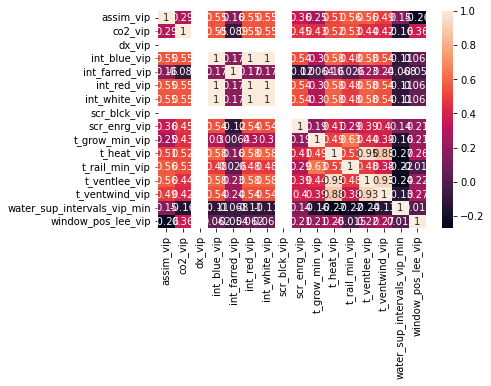

In [21]:
sns.heatmap(corr_table, annot=True)

### 3. Grodan Sensors

In [22]:
grodan = pd.read_csv("GrodanSens.csv")
grodan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47809 entries, 0 to 47808
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   %time     47809 non-null  float64
 1   EC_slab1  47809 non-null  object 
 2   EC_slab2  47809 non-null  object 
 3   WC_slab1  47809 non-null  object 
 4   WC_slab2  47809 non-null  object 
 5   t_slab1   47809 non-null  object 
 6   t_slab2   47809 non-null  object 
dtypes: float64(1), object(6)
memory usage: 2.6+ MB


In [23]:
grodan.rename(columns={"%time": "Time"}, inplace=True)
grodan['Time'] = pd.to_datetime(grodan['Time'], unit='D', origin='1899-12-30')
grodan.set_index("Time", inplace=True)

for col in grodan.columns:
    grodan[col] = grodan[col].astype(float)

In [24]:
grodan.isnull().sum() # Less than 5% is missing, can be dropped

EC_slab1    2306
EC_slab2    2306
WC_slab1    2306
WC_slab2    2306
t_slab1     2306
t_slab2     2306
dtype: int64

In [25]:
grodan.dropna(inplace=True)

<AxesSubplot:>

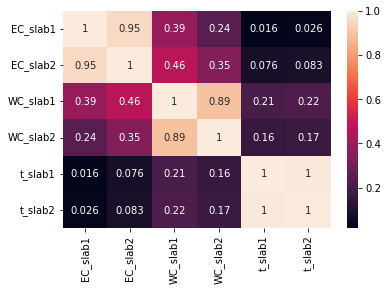

In [26]:
sns.heatmap(grodan.corr(), annot=True)

### 4. Lab Analysis

In [27]:
lab_analysis = pd.read_csv("LabAnalysis.csv")
lab_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 39 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   %Time       10 non-null     int64  
 1   irr_PH      10 non-null     float64
 2   irr_EC      10 non-null     float64
 3   irr_NH4     10 non-null     float64
 4   irr_K       10 non-null     float64
 5   irr_Na      10 non-null     float64
 6   irr_Ca      10 non-null     float64
 7   irr_Mg      10 non-null     float64
 8   irr_Si      10 non-null     float64
 9   irr_NO3     10 non-null     float64
 10  irr_Cl      10 non-null     float64
 11  irr_SO4     10 non-null     float64
 12  irr_HCO3    10 non-null     float64
 13  irr_PO4     10 non-null     float64
 14  irr_Fe      10 non-null     float64
 15  irr_Mn      10 non-null     float64
 16  irr_Zn      10 non-null     float64
 17  irr_B       10 non-null     float64
 18  irr_Cu      10 non-null     float64
 19  irr_Mo      10 non-null     floa

In [28]:
lab_analysis.rename(columns={"%Time": "Time"}, inplace=True)
lab_analysis['Time'] = pd.to_datetime(lab_analysis['Time'], unit='D', origin='1899-12-30')
lab_analysis.set_index("Time", inplace=True)

In [29]:
corr_table = lab_analysis.corr()
for i in corr_table.index:
    for j in corr_table.columns:
        if i == j:
            continue

        else:
            if np.abs(corr_table.loc[i,j]) >= 0.6:
                print(f"{i} and {j} are correlated, {corr_table.loc[i,j]}")

irr_PH and irr_EC are correlated, -0.9181853112627268
irr_PH and irr_Ca are correlated, -0.9115100455392064
irr_PH and irr_Mg are correlated, -0.9544222269215147
irr_PH and irr_Si are correlated, -0.7564141154078164
irr_PH and irr_NO3 are correlated, -0.8966244023647977
irr_PH and irr_SO4 are correlated, -0.9507952149629425
irr_PH and irr_PO4 are correlated, -0.8120650685966327
irr_PH and drain_Si are correlated, 0.6073108784838587
irr_PH and drain_HCO3 are correlated, -0.6881569481016648
irr_PH and drain_B are correlated, -0.629809677991368
irr_EC and irr_PH are correlated, -0.9181853112627268
irr_EC and irr_Ca are correlated, 0.8020836509760231
irr_EC and irr_Mg are correlated, 0.906140156273962
irr_EC and irr_Si are correlated, 0.6477095623880873
irr_EC and irr_NO3 are correlated, 0.7946594489603608
irr_EC and irr_Cl are correlated, 0.6867034567114381
irr_EC and irr_SO4 are correlated, 0.9360716004058214
irr_EC and irr_PO4 are correlated, 0.9173226417210204
irr_EC and drain_HCO3 are

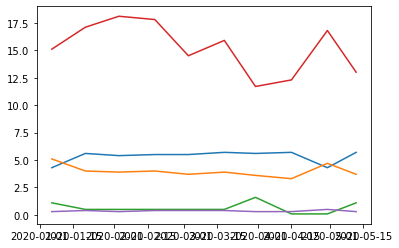

In [30]:
for i in range(5):
    col = lab_analysis.columns[i]
    plt.plot(lab_analysis.index, lab_analysis[col])

# Not very representative

### 5. Production

In [31]:
production = pd.read_csv("Production.csv")
production.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   %time                     24 non-null     int64  
 1   ProdA                     24 non-null     float64
 2   ProdB                     24 non-null     float64
 3   avg_nr_harvested_trusses  23 non-null     float64
 4   Truss development time    24 non-null     int64  
 5   Nr_fruits_ClassA          22 non-null     float64
 6   Weight_fruits_ClassA      24 non-null     float64
 7   Nr_fruits_ClassB          24 non-null     int64  
 8   Weight_fruits_ClassB      24 non-null     int64  
dtypes: float64(5), int64(4)
memory usage: 1.8 KB


In [32]:
production.rename(columns={"%time": "Time"}, inplace=True)
production['Time'] = pd.to_datetime(production['Time'], unit='D', origin='1899-12-30')
production.set_index("Time", inplace=True)

In [33]:
production.dropna(inplace=True)

<AxesSubplot:>

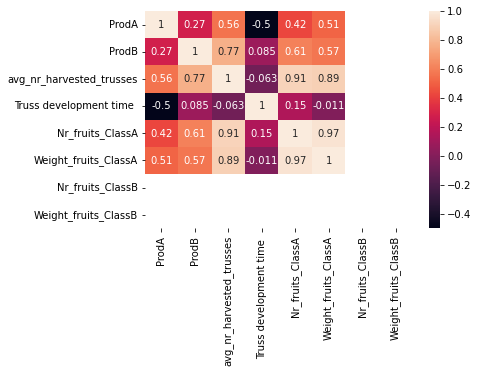

In [34]:
sns.heatmap(production.corr(), annot=True)

### 6. Resources

In [35]:
resources = pd.read_csv("Resources.csv")
resources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   %Time      166 non-null    float64
 1   Heat_cons  166 non-null    float64
 2   ElecHigh   166 non-null    float64
 3   ElecLow    166 non-null    float64
 4   CO2_cons   166 non-null    float64
 5   Irr        166 non-null    float64
 6   Drain      166 non-null    float64
dtypes: float64(7)
memory usage: 9.2 KB


In [36]:
resources.rename(columns={"%Time": "Time"}, inplace=True)
resources['Time'] = pd.to_datetime(resources['Time'], unit='D', origin='1899-12-30')
resources.set_index("Time", inplace=True)

<AxesSubplot:>

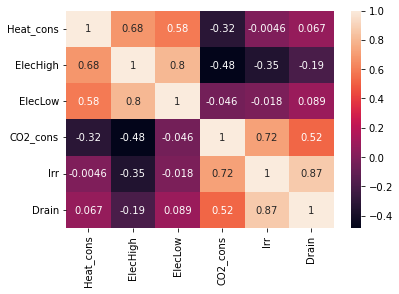

In [37]:
sns.heatmap(resources.corr(), annot=True)

### 7. TomQuality

In [38]:
tom_qual = pd.read_csv("TomQuality.csv")
tom_qual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   %time      8 non-null      int64  
 1   Flavour    8 non-null      int64  
 2   TSS        8 non-null      float64
 3   Acid       8 non-null      float64
 4   %Juice     8 non-null      int64  
 5   Bite       8 non-null      int64  
 6   Weight     8 non-null      float64
 7   DMC_fruit  6 non-null      float64
dtypes: float64(4), int64(4)
memory usage: 640.0 bytes


In [39]:
tom_qual.rename(columns={"%time": "Time"}, inplace=True)
tom_qual['Time'] = pd.to_datetime(tom_qual['Time'], unit='D', origin='1899-12-30')
tom_qual.set_index("Time", inplace=True)

In [41]:
imputer = IterativeImputer(estimator=LinearRegression())
cols = tom_qual.columns
inds = tom_qual.index
data = imputer.fit_transform(tom_qual)
tom_qual = pd.DataFrame(data=data, columns=cols, index=inds)

<AxesSubplot:>

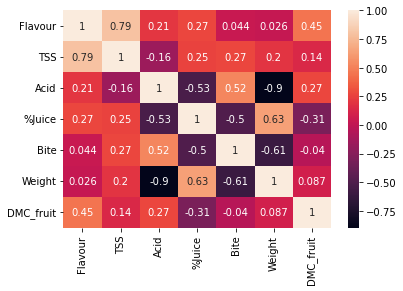

In [43]:
sns.heatmap(tom_qual.corr(), annot=True)

### Merging datasets

In [60]:
green_house = pd.merge(indoor_df, sp_df, left_index=True, right_index=True)
green_house = pd.merge(green_house, vip_df, left_index=True, right_index=True)

In [62]:
# Greenhouse climate and tomato quality
df1 = pd.merge(green_house, tom_qual, left_index=True, right_index=True)

corr_table = df1.corr()
for i in corr_table.index:
    for j in corr_table.columns:
        if i == j:
            continue

        else:
            if np.abs(corr_table.loc[i,j]) >= 0.6:
                print(f"{i} and {j} are correlated, {corr_table.loc[i,j]}")

BlackScr and Cum_irr are correlated, 0.7960659358032116
BlackScr and EC_drain_PC are correlated, -0.7764074587789356
BlackScr and EnScr are correlated, -0.9661375111958893
BlackScr and PipeLow are correlated, 0.8713295298012105
BlackScr and pH_drain_PC are correlated, 0.7934751515769072
BlackScr and water_sup are correlated, 0.7865307543803028
BlackScr and scr_blck_sp are correlated, 0.8021094316722702
BlackScr and scr_enrg_sp are correlated, -0.9711288508449032
BlackScr and t_heat_sp are correlated, -0.6187861128494474
BlackScr and co2_vip are correlated, 0.7614514453776176
BlackScr and int_blue_vip are correlated, 0.7799822749364836
BlackScr and int_red_vip are correlated, 0.7799822749364836
BlackScr and int_white_vip are correlated, 0.7799822749364836
BlackScr and scr_enrg_vip are correlated, -0.9983829761016629
BlackScr and Acid are correlated, 0.8136885286155807
BlackScr and Weight are correlated, -0.8674133949361483
CO2air and TSS are correlated, 0.6110476357667077
CO2air and %Ju

In [63]:
# Resources and tomato quality
df2 = pd.merge(resources, tom_qual, left_index=True, right_index=True)

corr_table = df2.corr()
for i in corr_table.index:
    for j in corr_table.columns:
        if i == j:
            continue

        else:
            if np.abs(corr_table.loc[i,j]) >= 0.6:
                print(f"{i} and {j} are correlated, {corr_table.loc[i,j]}")

Heat_cons and ElecHigh are correlated, 0.6382704597378134
Heat_cons and Weight are correlated, -0.6405313103734739
ElecHigh and Heat_cons are correlated, 0.6382704597378134
ElecHigh and ElecLow are correlated, 0.8760900962239084
ElecHigh and Acid are correlated, 0.9443492230013532
ElecHigh and Weight are correlated, -0.8900019013696501
ElecLow and ElecHigh are correlated, 0.8760900962239084
ElecLow and CO2_cons are correlated, 0.6988674937570434
ElecLow and Irr are correlated, 0.6092215863630902
ElecLow and Acid are correlated, 0.8426905008056346
ElecLow and Weight are correlated, -0.878346313723537
CO2_cons and ElecLow are correlated, 0.6988674937570434
CO2_cons and %Juice are correlated, -0.6238031108953339
CO2_cons and Bite are correlated, 0.6314135059271843
Irr and ElecLow are correlated, 0.6092215863630902
Irr and Drain are correlated, 0.9344294966696272
Irr and DMC_fruit are correlated, -0.6059609979363286
Drain and Irr are correlated, 0.9344294966696272
Drain and DMC_fruit are c